In [ ]:
import cfgrib
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [ ]:
data_path = "/Users/fquareng/AdaptationSandbox/data/6e647e250b9f05c076fff6a2a43b49da.grib"

**Note**: ERA5 GRIB files that contain multiple variables, such as t2m (2-meter temperature) and tp (total precipitation), can cause issues because cfgrib requires uniform metadata for each dataset. 

**Note**: The *shortName* is different from the *Data Variables* entry.

In [82]:
surf_data = xr.open_dataset(data_path, engine="cfgrib", filter_by_keys={"shortName": ["2t", "sp", "10u", "10v"]})
tp_data = xr.open_dataset(data_path, engine="cfgrib", filter_by_keys={"shortName": "tp"})
tp_data

<xarray.Dataset> Size: 29MB
Dimensions:     (time: 1848, step: 2, latitude: 117, longitude: 17)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 15kB 2010-12-31T18:00:00 ... 2021-12-07...
  * step        (step) timedelta64[ns] 16B 06:00:00 12:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  (time, step) datetime64[ns] 30kB ...
Data variables:
    tp          (time, step, latitude, longitude) float32 29MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-09T15:26 GRIB to CDM+CF via cfgrib-0.9.1...

# Plot

In [53]:
# Plotting function for consistent styling
def plot_variable(ax, var, title, cmap, units, vmin=None, vmax=None):
    """Plots a single variable with Cartopy."""
    var.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'label': units},
    )
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.8)
    ax.set_title(title)

In [65]:
# Select a specific time (e.g., 2011-01-01 00:00 UTC)
time_selection = "2011-01-01T06:00"
t2m = surf_data['t2m'].sel(time=time_selection)
u10 = surf_data['u10'].sel(time=time_selection)
v10 = surf_data['v10'].sel(time=time_selection)
sp = surf_data['sp'].sel(time=time_selection)
print(sp)

<xarray.DataArray 'sp' (latitude: 117, longitude: 17)> Size: 8kB
[1989 values with dtype=float32]
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B 2011-01-01T06:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             134
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1989
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sp
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:         

In [64]:
time_selection = "2011-01-01T06:00"
tp = tp_data['tp'].sel(time=time_selection, method='nearest', step="06:00:00")
print(tp)

<xarray.DataArray 'tp' (latitude: 117, longitude: 17)> Size: 8kB
[1989 values with dtype=float32]
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B 2011-01-01T06:00:00
    step        timedelta64[ns] 8B 06:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 936B 62.0 61.75 61.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 136B 6.0 6.25 6.5 6.75 ... 9.5 9.75 10.0
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1989
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_shortName:                           tp
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:       

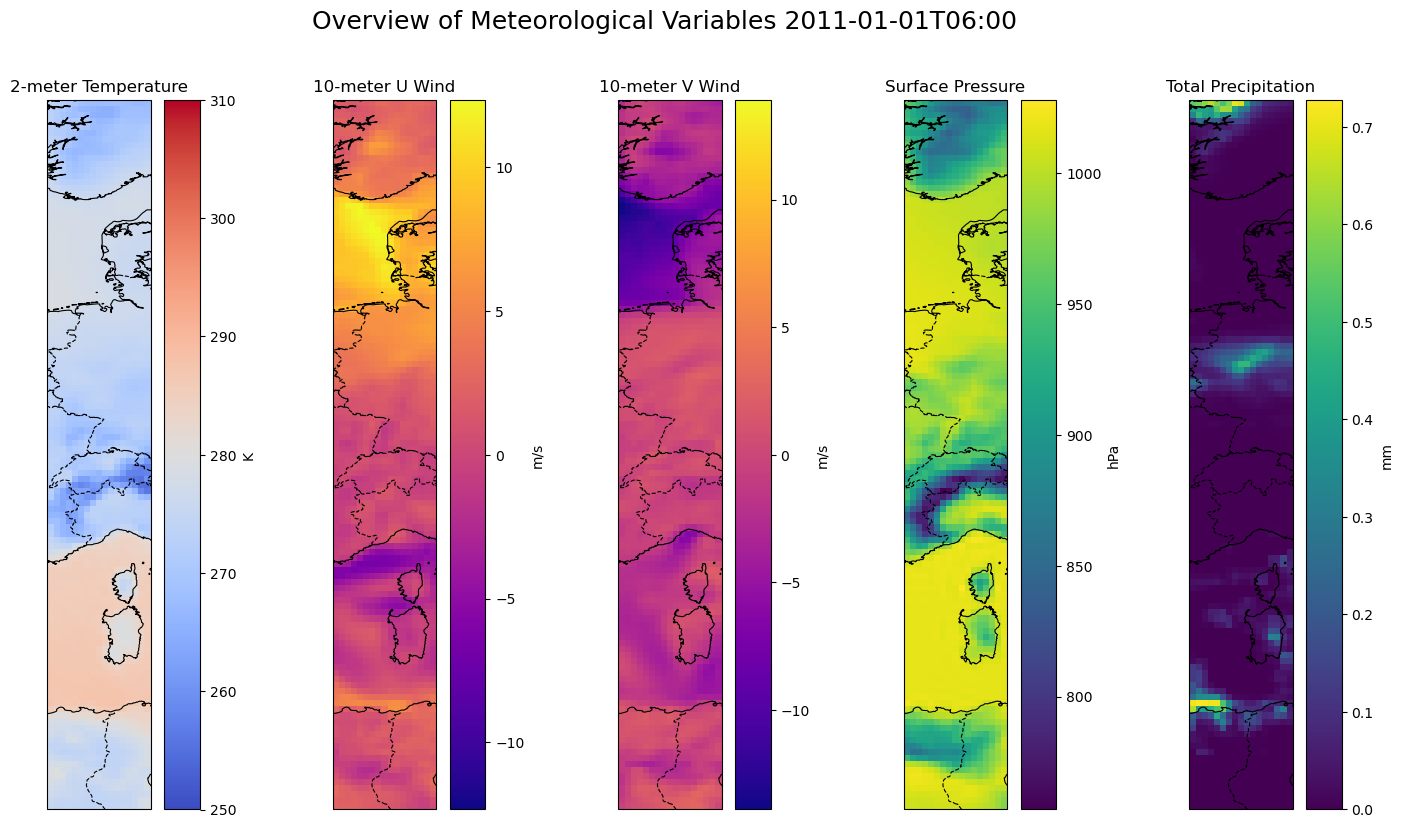

In [81]:
# Create the figure with horizontal subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})


# Plot each variable
plot_variable(axs[0], t2m, "2-meter Temperature", "coolwarm", "K", vmin=250, vmax=310)
plot_variable(axs[1], u10, "10-meter U Wind", "plasma", "m/s")
plot_variable(axs[2], v10, "10-meter V Wind", "plasma", "m/s")
plot_variable(axs[3], sp / 100, "Surface Pressure", "viridis", "hPa")  # Convert Pa to hPa
plot_variable(axs[4], tp * 1000, "Total Precipitation", "viridis", "mm")

fig.suptitle(f"Overview of Meteorological Variables {time_selection}", fontsize=18, y=1.02)

# Adjust layout
plt.tight_layout()


## Monthly mean distribution

In [149]:
t2m = surf_data['t2m'] 
monthly_mean = t2m.groupby('time.month').mean(dim=['time'])

In [150]:
jfm = [monthly_mean.groupby('month')[1], monthly_mean.groupby('month')[2], monthly_mean.groupby('month')[3]]
amj = [monthly_mean.groupby('month')[4], monthly_mean.groupby('month')[5], monthly_mean.groupby('month')[6]]
jas = [monthly_mean.groupby('month')[7], monthly_mean.groupby('month')[8], monthly_mean.groupby('month')[9]]
ond = [monthly_mean.groupby('month')[10], monthly_mean.groupby('month')[11], monthly_mean.groupby('month')[12]]

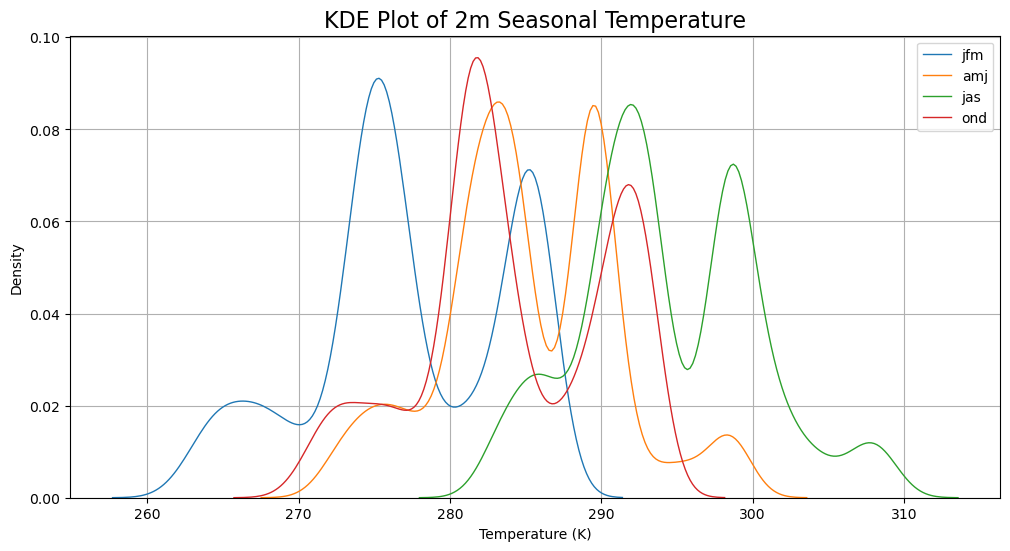

In [151]:
plt.figure(figsize=(12, 6))
plt.title("KDE Plot of 2m Seasonal Temperature", fontsize=16)
plt.xlabel("Temperature (K)")
plt.ylabel("Density")
plt.grid(True)

sns.kdeplot(jfm[1].values.flatten(), linewidth=1, label=f"jfm")
sns.kdeplot(amj[1].values.flatten(), linewidth=1, label=f"amj")
sns.kdeplot(jas[1].values.flatten(), linewidth=1, label=f"jas")
sns.kdeplot(ond[1].values.flatten(), linewidth=1, label=f"ond")

plt.legend()
plt.show()


In [152]:
tp = tp_data['tp'] 
monthly_mean = tp.groupby('time.month').mean(dim=['time', 'step'])


In [153]:
jfm = [monthly_mean.groupby('month')[1], monthly_mean.groupby('month')[2], monthly_mean.groupby('month')[3]]
amj = [monthly_mean.groupby('month')[4], monthly_mean.groupby('month')[5], monthly_mean.groupby('month')[6]]
jas = [monthly_mean.groupby('month')[7], monthly_mean.groupby('month')[8], monthly_mean.groupby('month')[9]]
ond = [monthly_mean.groupby('month')[10], monthly_mean.groupby('month')[11], monthly_mean.groupby('month')[12]]

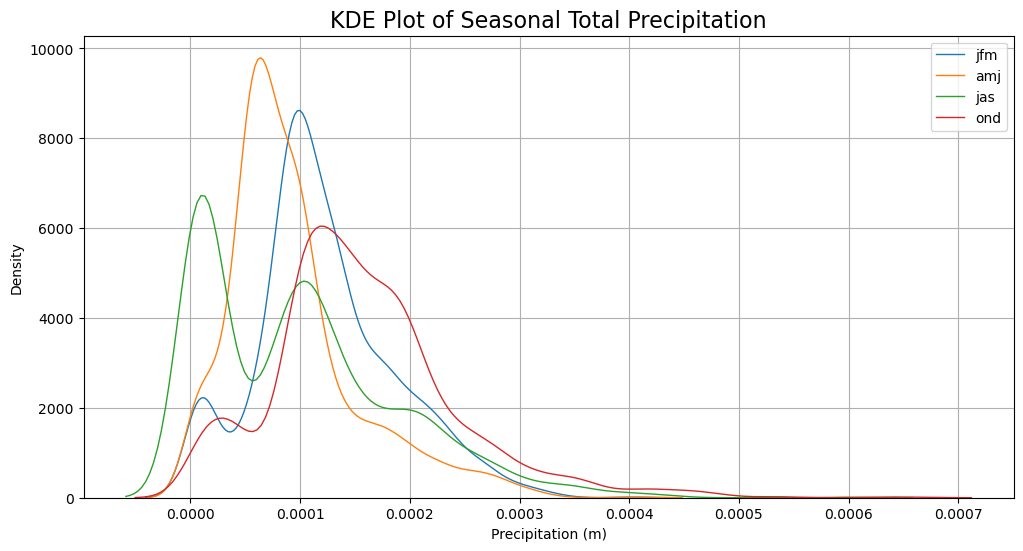

In [154]:
plt.figure(figsize=(12, 6))
plt.title("KDE Plot of Seasonal Total Precipitation", fontsize=16)
plt.xlabel("Precipitation (m)")
plt.ylabel("Density")
plt.grid(True)

sns.kdeplot(jfm[1].values.flatten(), linewidth=1, label=f"jfm")
sns.kdeplot(amj[1].values.flatten(), linewidth=1, label=f"amj")
sns.kdeplot(jas[1].values.flatten(), linewidth=1, label=f"jas")
sns.kdeplot(ond[1].values.flatten(), linewidth=1, label=f"ond")

plt.legend()
plt.show()
